# Reattachment of Cargo

Thusfar, we have considered the delivery of cargo as a one-step irreversible reaction. It is possible that cargo is reattached to the motors to undergo further trafficking. Reattachment isn't necessarily a universal feature of caro trafficking &mdash; it would not model situations where cargo is rapidly recruited after detachment, or if the reattachment process is very slow/expensive (e.g. the reassembly of a mRNA granule).

**Sushi-Belt Model with Reattachment:**

$$
\begin{array}{cccccccc}
u_1 & \overset{a_1}{\underset{b_1}{\rightleftharpoons}} &
u_2 & \overset{a_2}{\underset{b_2}{\rightleftharpoons}} &
u_3 & \overset{a_3}{\underset{b_3}{\rightleftharpoons}} &
u_4 & \overset{a_4}{\underset{b_4}{\rightleftharpoons}} ...
\\
d_1 \Bigg\uparrow\Bigg\downarrow c_1 & &
d_2 \Bigg\uparrow\Bigg\downarrow c_2 & &
d_3 \Bigg\uparrow\Bigg\downarrow c_3 & &
d_4 \Bigg\uparrow\Bigg\downarrow c_4 & 
\\
u_1^\star &  &
u_2^\star &  &
u_3^\star &  &
u_4^\star &  
\end{array}
$$

**High-level summary of results:**

Following equations (2-3) in the *Results*, the steady-state ratio of trafficked cargo to detached cargo is given by:

$$
\frac{u_i}{u_i^\star} \Bigg\vert_{ss} = \frac{d_i}{c_i}
$$

If this ratio is small, then most of the cargo will be released and recruited for local processes. When this ratio is large, then there is *excess cargo* left on the microtubules. Having large amounts of excess cargo may be undesirable since (1) a large proportion of cargo is synthesized without being used/recruited, and (2) excess cargo may produce traffic jams on the microtubules (see, e.g., [Leduc et al., 2012](dx.doi.org/10.1073/pnas.1107281109)).

One way to reduce excess cargo is to make the reattachment rates $d_i$ small. In the limit as $d_i \rightarrow 0$ there is no excess cargo at steady-state. This scenario maps onto the models analyzed in figures 4-6, and suffers from a speed-accuracy tradeoff in which a proximal biases in cargo delivery develop unless detachment is very slow relative to trafficking.

Another way to reduce excess cargo is to make the detachment rates large, so that $d_i < c_i$.

First, consider the case where $c_i$ is much larger than $d_i$. This causes a large proportion of cargo to rapidly detach in the proximal portion of the dendrites. In the detached state, the cargo is stationary; it must reattach to the microtubules to be transported down the cable. Because it is energetically favorable for the cargo to be in the detached state, it takes a long time for cargo to be trafficked down the length of the cable.

Second, consider the case were $c_i$ is large, but $d_i$ is much larger on average. In this case, the majority of cargo will stay on the microtubules, leading to large excesses. However, the system will reach steady-state quicker because fewer cargoes are trapped in the detached state in proximal compartments.

Thus, there is a tradeoff between how quickly the system reaches steady-state and how much cargo is left on the microtubules. Interestingly, this tradeoff is ***least severe*** when the detachment and reattachment rates are both very large. ***This is an experimentally testable prediction.***

The sushi-belt model with reattachment maps onto a more abstract model &mdash; diffusion with local traps. The principle is that each delivery site in the sushi belt model acts as a trap to prevent diffusion of cargo. Diffusion with traps has been extensively studied in the physics community. For simple systems one can find analytic expressions for the *effective diffusion coefficient* which decreases as (1) the density of local traps increases, (2) the propensity for particles to enter traps increases (in our case, this corresponds to the ratio $c_i / d_i$ increasing). [Bressloff &amp; Earnshaw (2007)](http://dx.doi.org/10.1103/PhysRevE.75.041915) calculate an effective diffusion coefficient for the case of uniformly distributed spines in a cable with uniform trafficking rates.

In [1]:
from __future__ import division
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import expm # matrix exponential solves linear system
import matplotlib.pyplot as plt
from time import sleep
%matplotlib inline

/Users/alex/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from __future__ import division
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import expm # matrix exponential solves linear system
import pylab as plt
from time import sleep
%matplotlib inline

# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation

N = 100 # number of compartments
x = np.linspace(0,1,N) # position along cable
DC = 0.5 # diffusion coeff (normalized to compartment length)

def get_target_profile(n_syn,syn_loc=None):
    # Calculate target profile, y
    if syn_loc is None: syn_loc = np.linspace(0.1,0.9,n_syn)
    x = np.linspace(0,1,N)
    y = np.zeros(N)
    for i in syn_loc:
        y += 0.5*np.exp(-abs(x - x[int(i*N)])*100)
    return y

def get_matrix(y,c_scale,d_scale,bias=0.0):
    """Calculates the state-transition matrix, A"""
    
    # detachment rates
    c = c_scale*y
    
    # reattachment rates
    d = d_scale*np.ones(N)
    
    # trafficking rates, constrain so that a+b = DC/2
    a = np.linspace((DC/2.)+bias,(DC/2.),N-1)
    b = np.linspace((DC/2.)-bias,(DC/2.),N-1)
    
    # State-transition matrix:
    # 
    # A = [ A1 | A2
    #       A3 | A4 ]
    mid = -c
    mid[:-1] -= a
    mid[1:]  -= b
    A1 = np.diag(a, -1) + np.diag(mid) + np.diag(b, 1) # movement on microtubules, detaching cargo lost
    A2 = np.diag(d) # reattaching cargo recieved at microtubules
    A3 = np.diag(c) # detaching cargo recieved at synapses
    A4 = -np.diag(d) # reattaching cargo lost at synapses 
    
    # State-transition matrix
    A = np.array(np.bmat([[A1,A2],[A3,A4]]))
    
    # initial condition
    u0 = np.zeros(2*N)
    u0[0] = np.sum(y)
    
    return A,u0

def sim(cs,ds,t,n_syn=6,bias=0.0,filename=None):
    y = get_target_profile(n_syn)#np.ones(N)/N
    A,u0 = get_matrix(y,cs,ds,bias)
    
    if filename is not None:
        save_snapshots(A,u0,filename)
    
    # animation figure
    fig = plt.figure()
    ax1 = plt.subplot(2,1,1)
    plt.title('concentration on microtubule')
    line1, = ax1.plot([],[],lw=2)
    plt.ylim([-0.02,0.2]),plt.xlim([0,1])
    ax2 = plt.subplot(2,1,2)
    plt.title('detached concentration')
    line2, = ax2.plot([],[],lw=2)
    plt.ylim([-0.02,1.0]),plt.xlim([0,1])
    plt.tight_layout()

    def init():
        line1.set_data(x, u0[:N])
        line2.set_data(x, u0[N:])
        return line1,line2,

    def animate(i):
        u = np.dot(expm(A*t[i]),u0)
        line1.set_data(x, u[:N])
        line2.set_data(x, u[N:])
        ax1.set_title('concentration on microtubule: '+str(np.round(t[i]/60))+' mins')
        ax2.set_title('detached concentration: '+str(np.round(100*np.sum(u[N:])/np.sum(u),2))+'% detached')
        return line1,line2,
        
    return fig,animate,init

def save_snapshots(A,u0,filename):
    u75 = np.dot(expm(A*(75*60)),u0)
    u245 = np.dot(expm(A*(245*60)),u0)
    uss = np.dot(expm(A*(1440*60)),u0) # steady-state profile
    names = ['75mins','245mins','1 day']

    for u,n in zip([u75,u245,uss],names):
        plt.figure()
        plt.title(n)
        plt.plot(x,u[:N],'-b',lw=2)
        plt.plot(x,u[N:],'-r',lw=2)
        plt.ylim([-0.02,1.3]),plt.xlim([0,1])
        plt.legend(('on microtubule','detached'))
        plt.tight_layout()
        plt.savefig(filename+'_'+n+'.svg')
        plt.close()

def calc_tradeoff_curve(y,cs):
    tau,excess = [],[]
    for ds in np.logspace(-5,-1,20):
        A,u0 = get_matrix(y,cs,ds)
        tss,uss = calc_time_to_ss(A)
        uss = np.dot(expm(A*10*tss),u0) # steady-state profile
        excess.append(np.sum(uss[:N])/np.sum(uss))
        tau.append(tss)
    return np.array(tau),np.array(excess)

def calc_time_to_ss(A,ss_tol=1e-6,bound_tol=1.0):
    # calculate number of seconds to reach steady-state (within tol)
    u0 = np.ones(N*2)
    u0[0] = 1.0
    
    tt = 1.0
    u = np.dot(expm(A*tt),u0)
    upper_bound,lower_bound = 1e10,0.0
    while (upper_bound - lower_bound) > bound_tol:
        tt = lower_bound + (upper_bound-lower_bound)/2
        u = np.dot(expm(A*tt),u0)
        if np.linalg.norm(np.dot(A,u))/np.sqrt(N) > ss_tol:
            # not converged to steady-state
            lower_bound = tt
        else:
            # converged to steady-state
            upper_bound = tt
    tss = lower_bound + (upper_bound-lower_bound)/2
    return tss,np.dot(expm(A*tss*10),u0)

def err_vs_time(cs,ds,n_syn=6,bias=0.0,tmax=5.5):
    y = get_target_profile(n_syn)#np.ones(N)/N
    A,u0 = get_matrix(y,cs,ds,bias)
    u0[1] = 1.0
    uss = np.dot(expm(A*(10**(tmax+1))),u0)
    t = np.logspace(1.5,tmax,tmax*3)
    err,excess = [],[] 
    for tt in t:
        u = np.dot(expm(A*tt),u0)
        #err.append(np.mean( 100*np.abs(u[N:]-uss[N:])/u[N:] ))
        err.append( 100*np.mean( np.abs(u[N:]-uss[N:])/uss[N:]) )
        excess.append( 100*np.sum(u[:N])/np.sum(u) )
    return t,err,excess

## Reattachment faster than detachment: quick convergence, but excess cargo


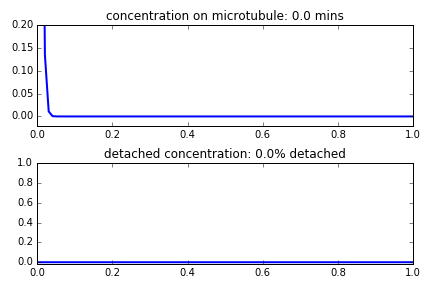
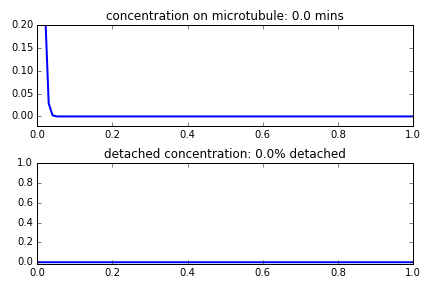
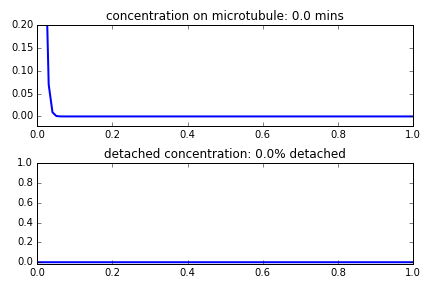
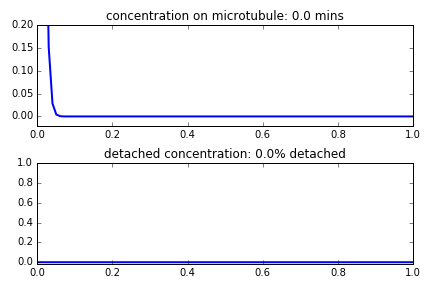
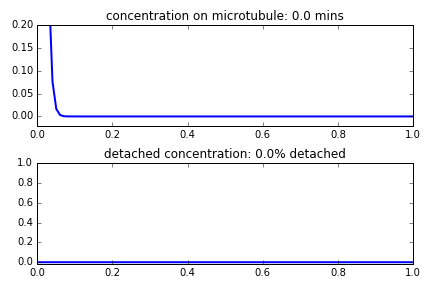
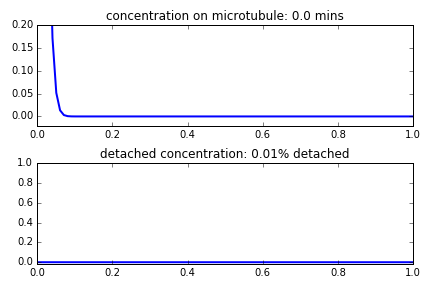
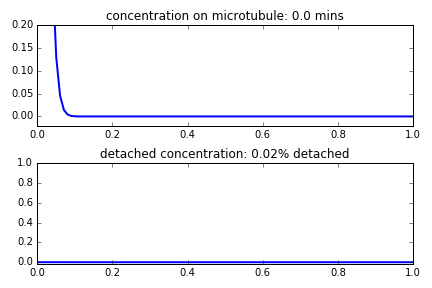
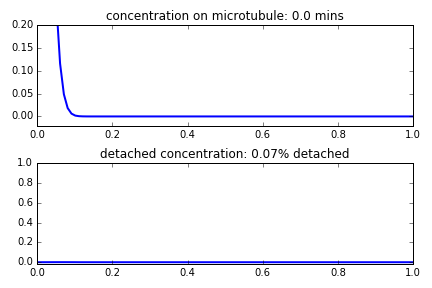
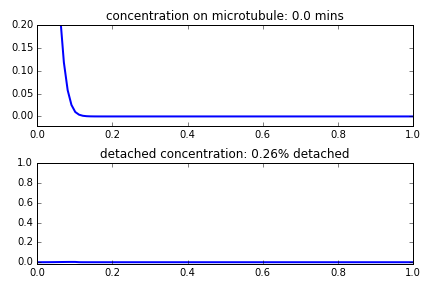
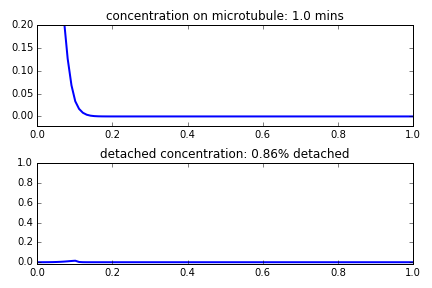
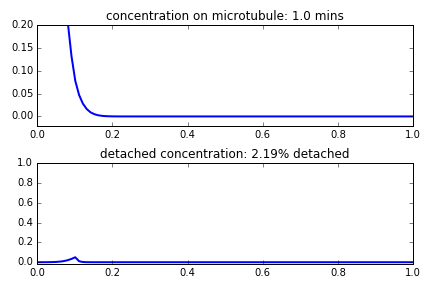
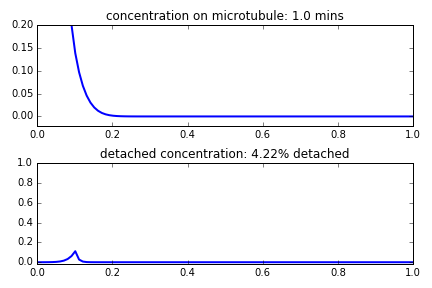
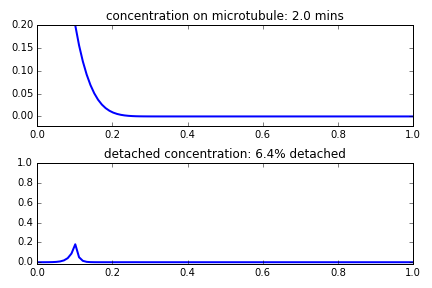
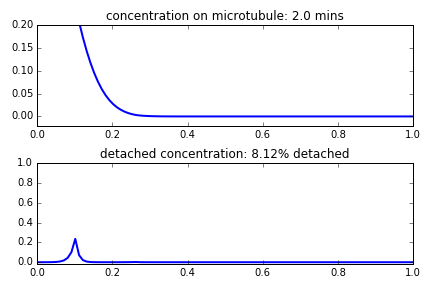
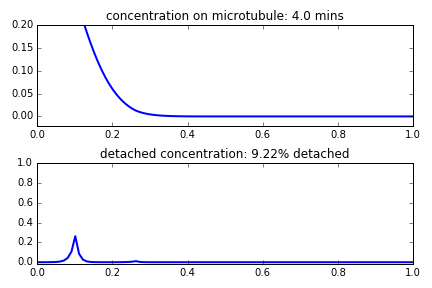
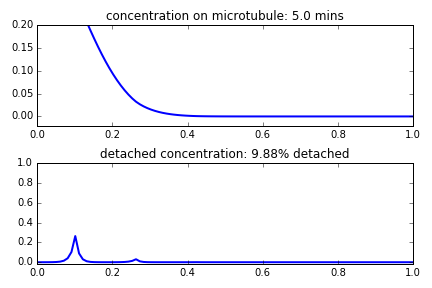
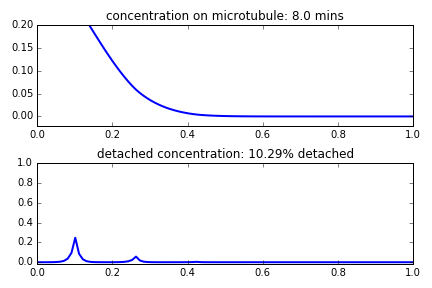
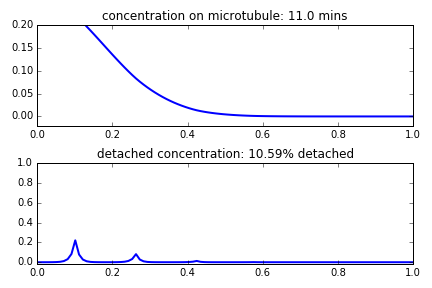
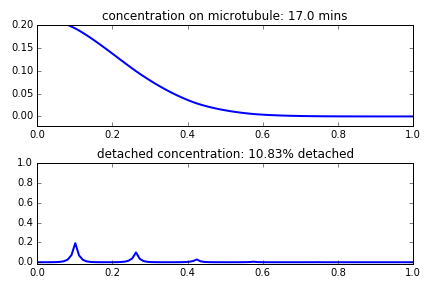
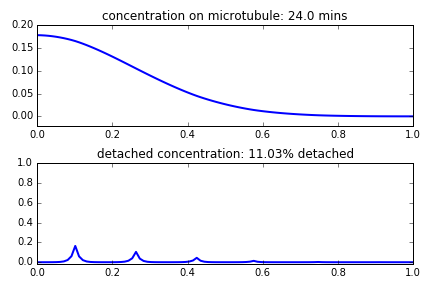
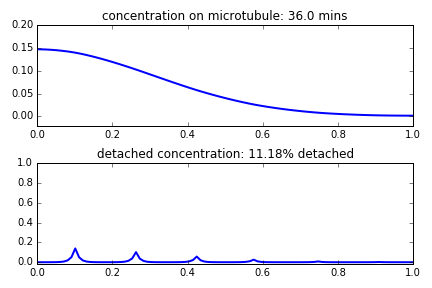
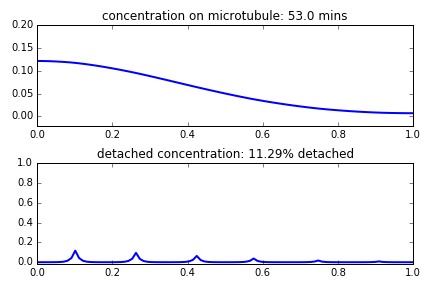
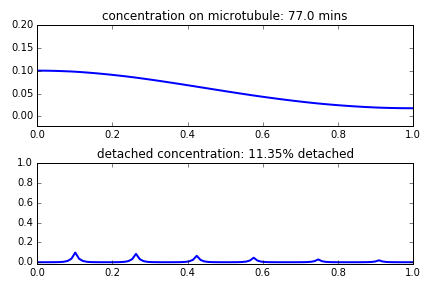
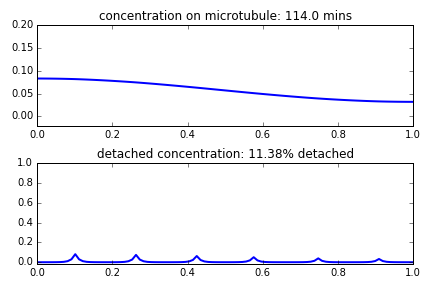
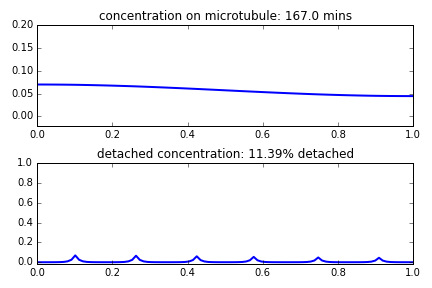
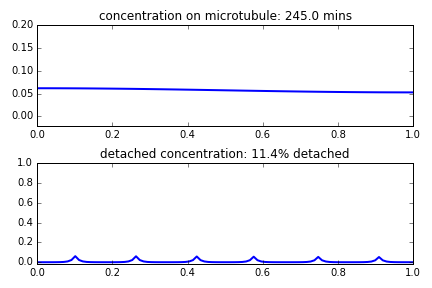
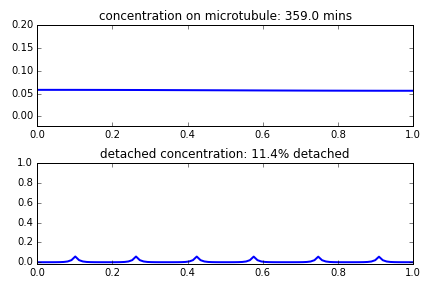
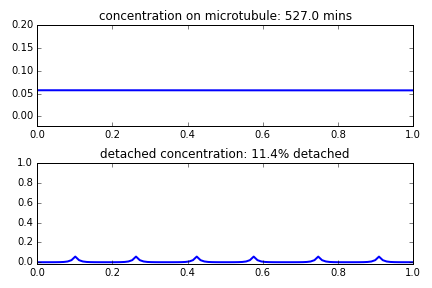
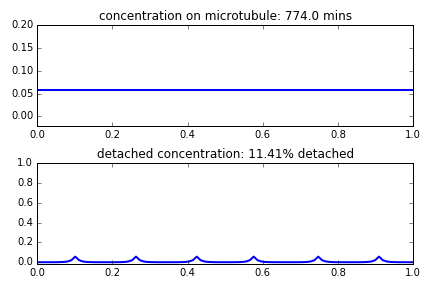
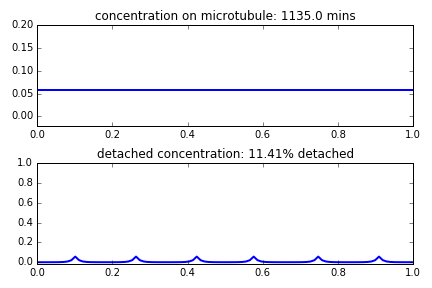
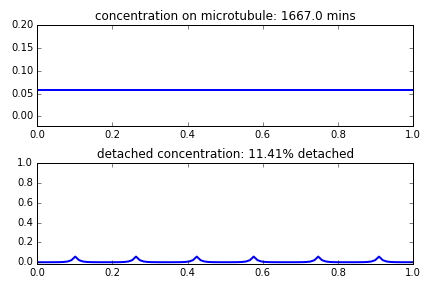
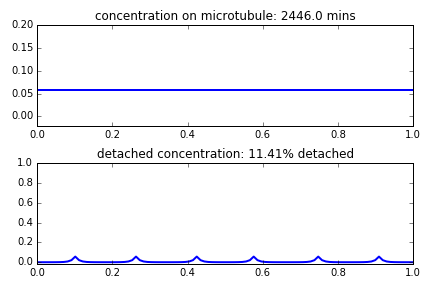
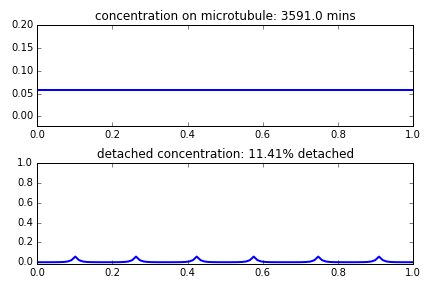
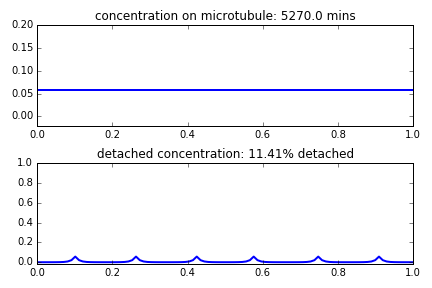
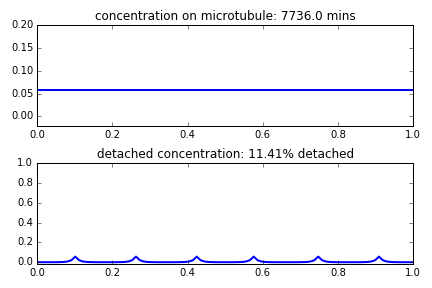
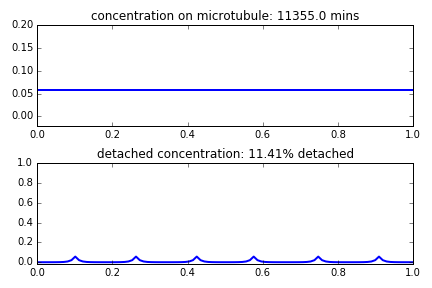
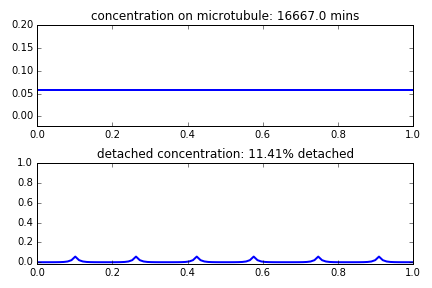
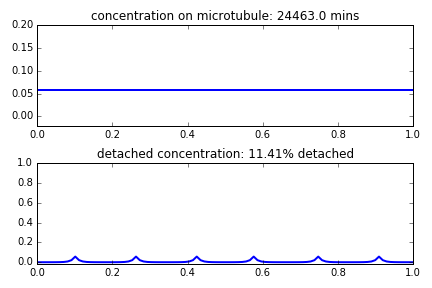
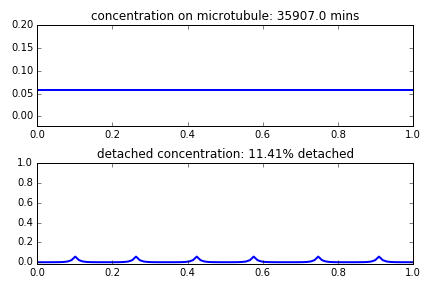
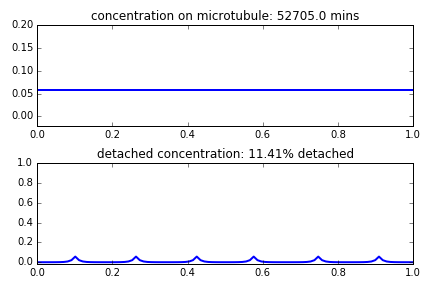

In [3]:
nt = 40
fig,animate,init = sim(2e-1,1e-1,np.logspace(0,6.5,nt),filename='01')
ani1 = animation.FuncAnimation(fig, animate, init_func=init, frames=nt, interval=100)
ani1.save('01.mp4'); ani1

## Detachment faster than reattachment: no excess cargo, slow convergence


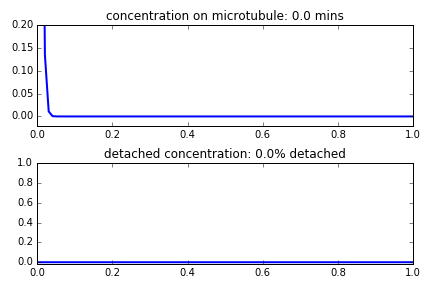
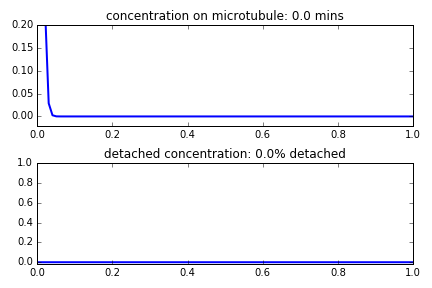
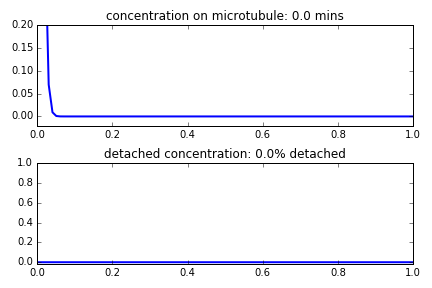
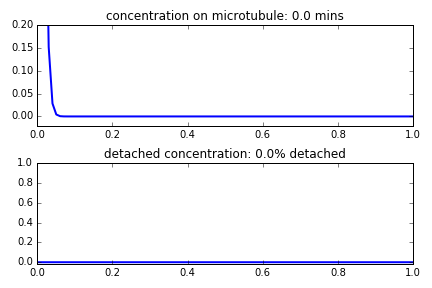
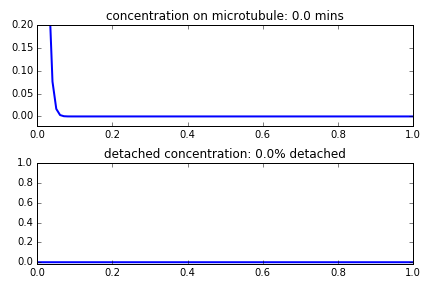
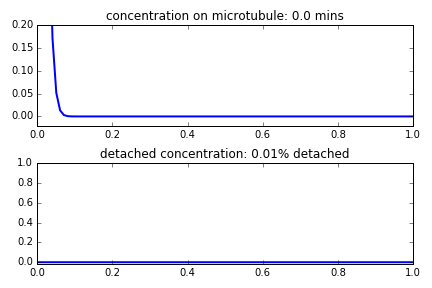
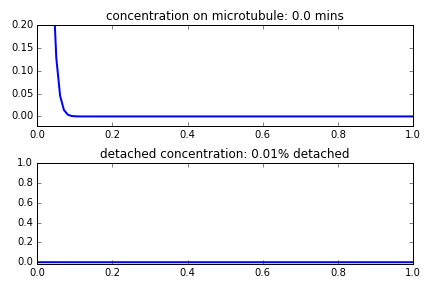
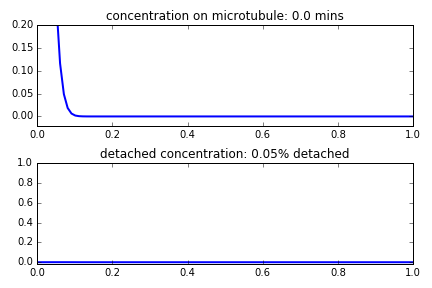
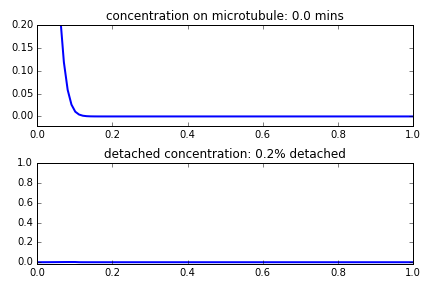
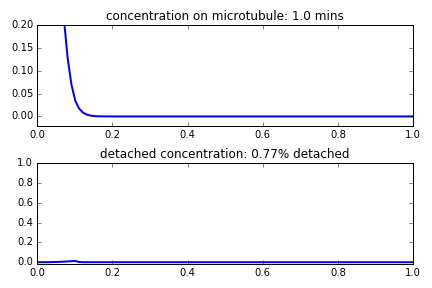
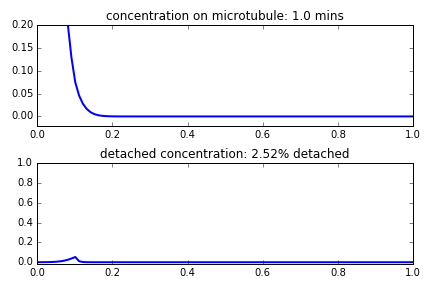
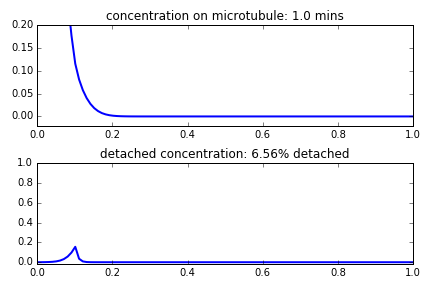
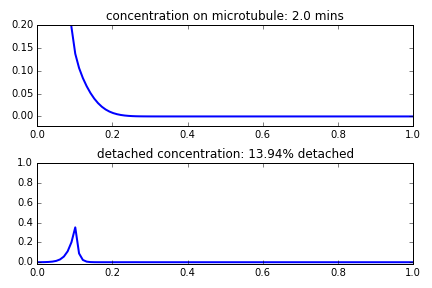
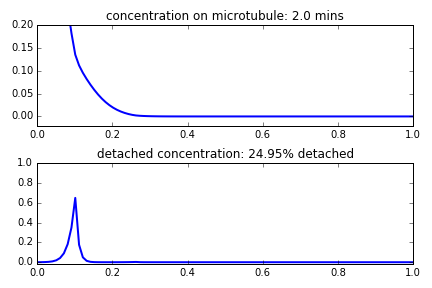
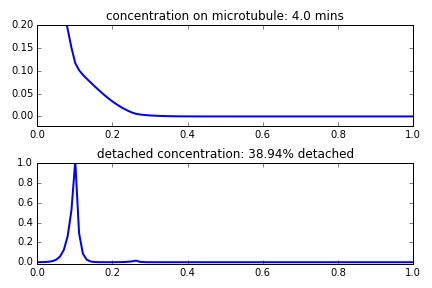
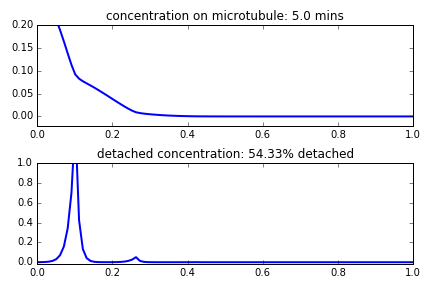
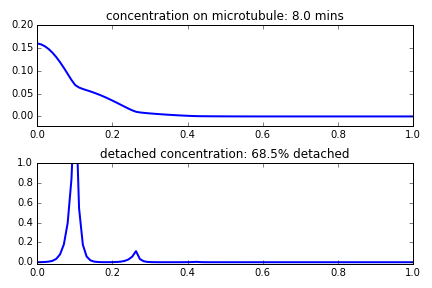
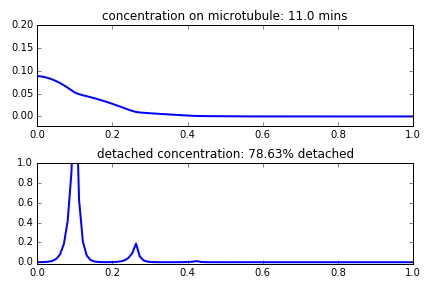
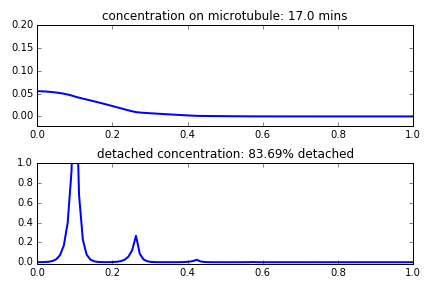
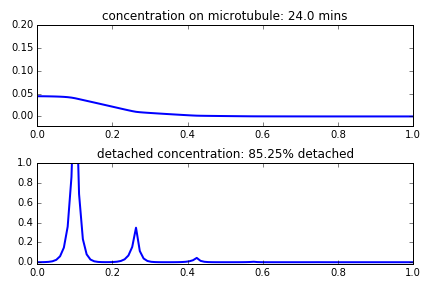
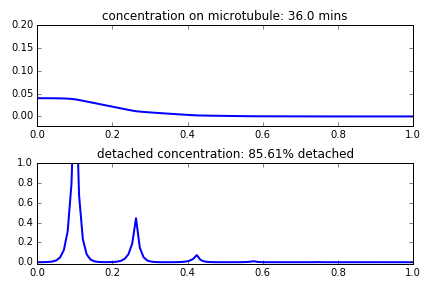
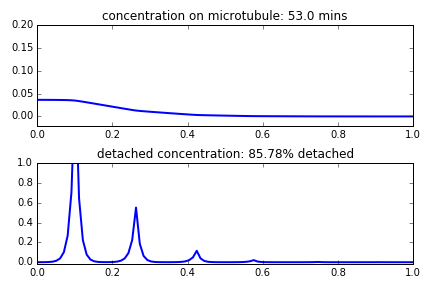
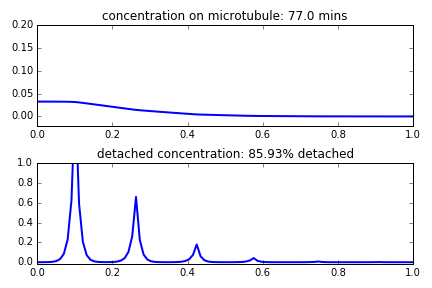
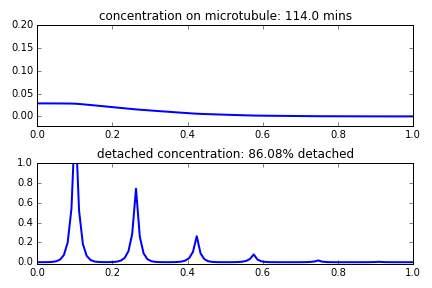
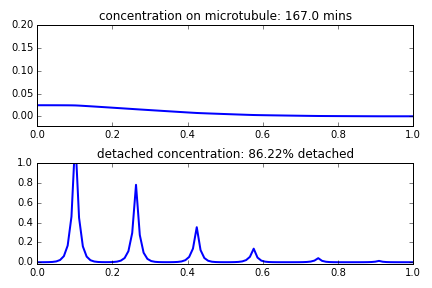
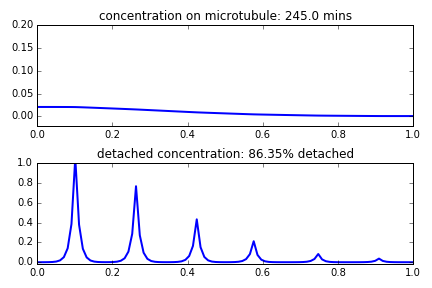
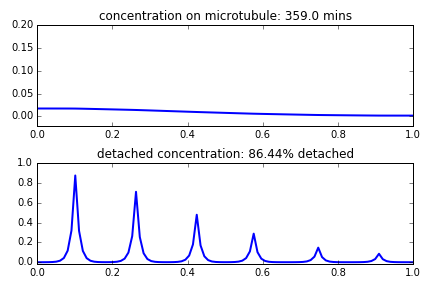
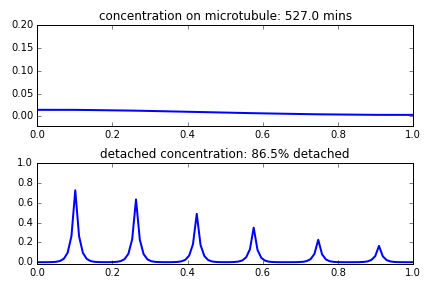
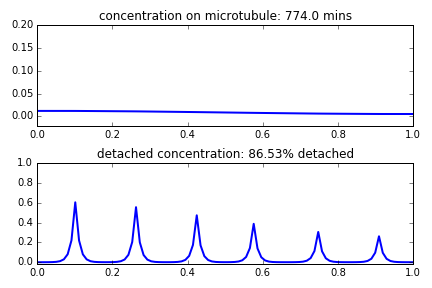
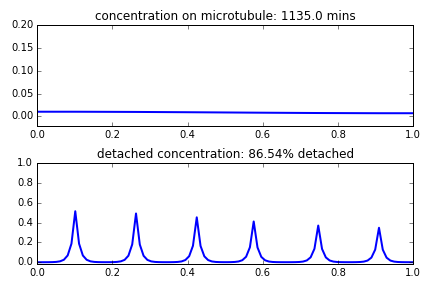
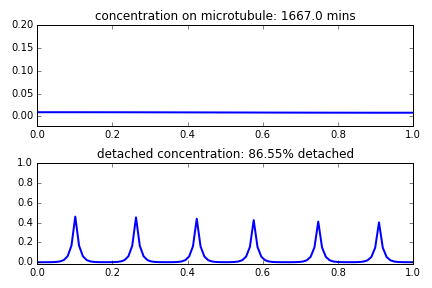
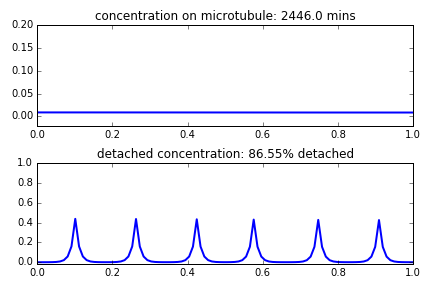
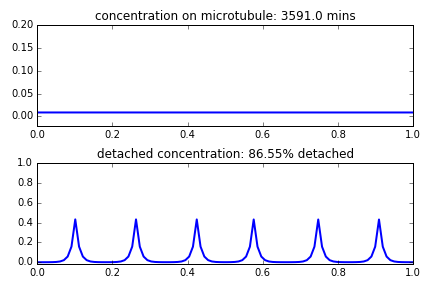
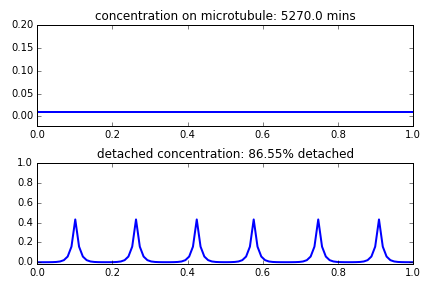
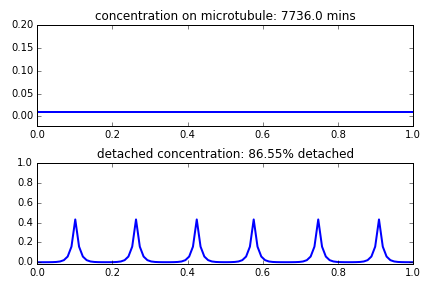
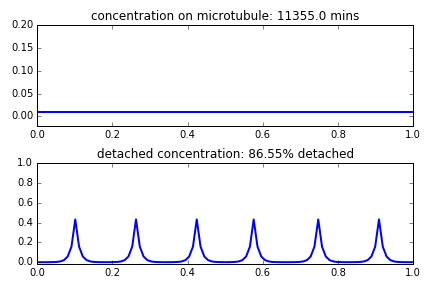
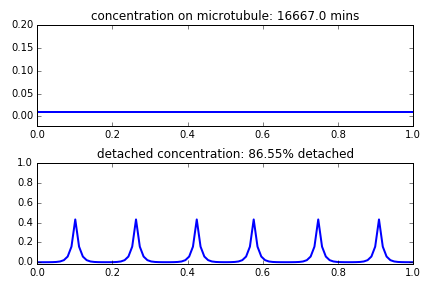
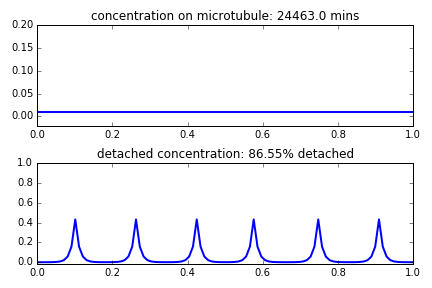
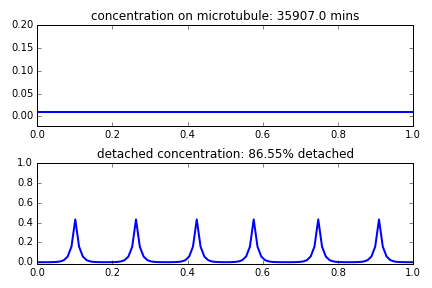
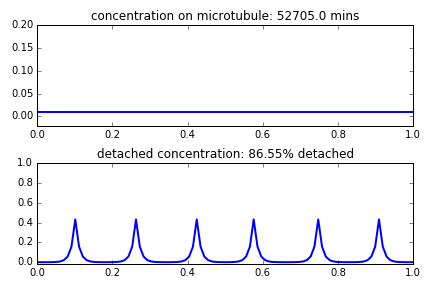

In [4]:
# fast detachment, slow reattachment
fig,animate,init = sim(1e-1,1e-3,np.logspace(0,6.5,nt),filename='02')
ani2 = animation.FuncAnimation(fig, animate, init_func=init, frames=nt, interval=100)
ani2.save('02.mp4'); ani2

## Slow detachment, slower reattachment: no excess cargo, slow convergence (similar to results in Fig. 5-6)


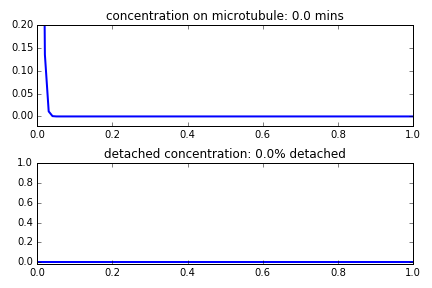
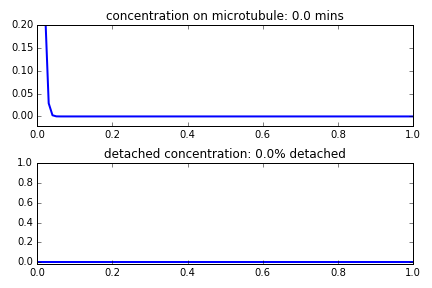
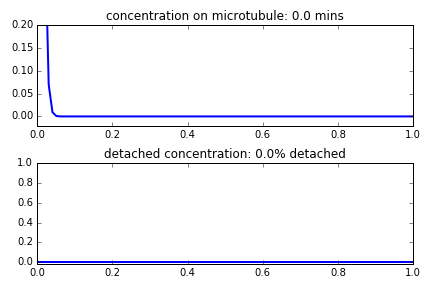
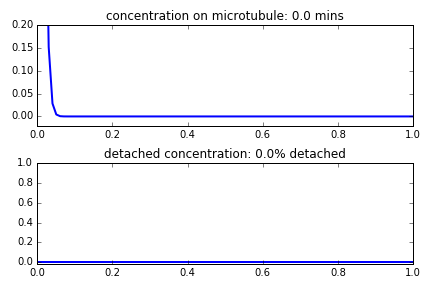
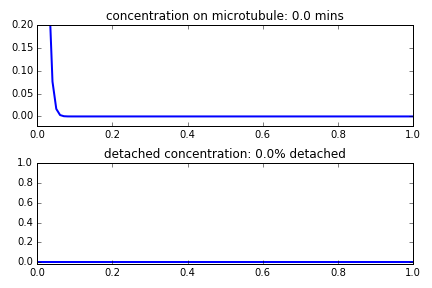
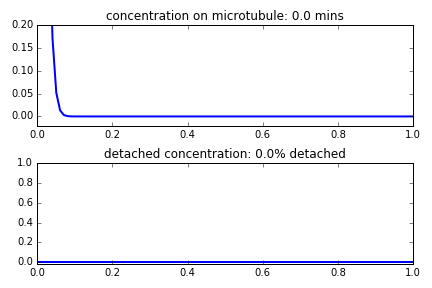
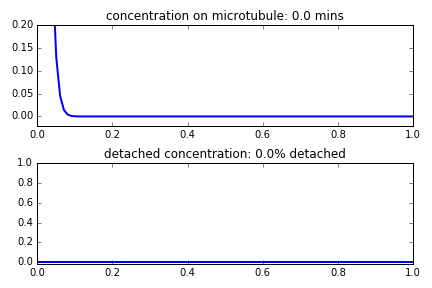
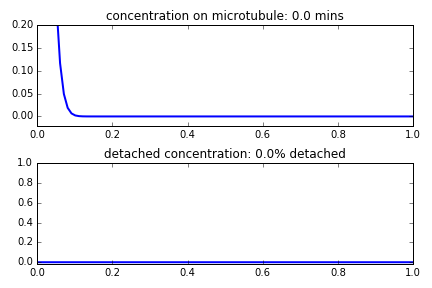
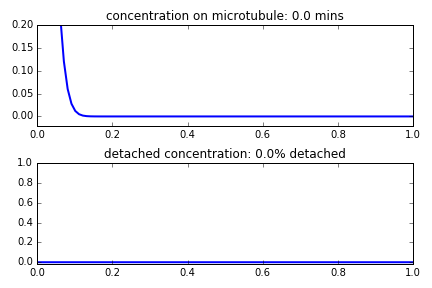
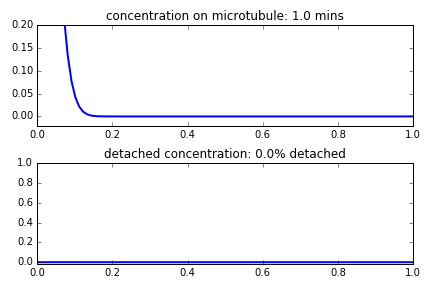
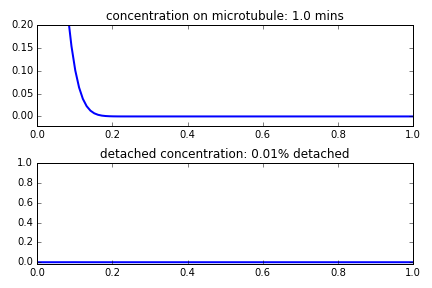
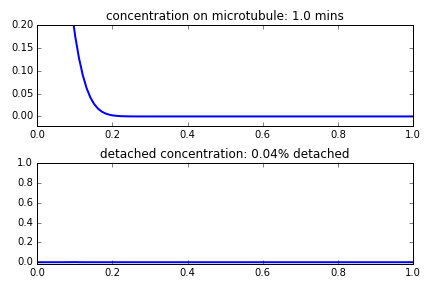
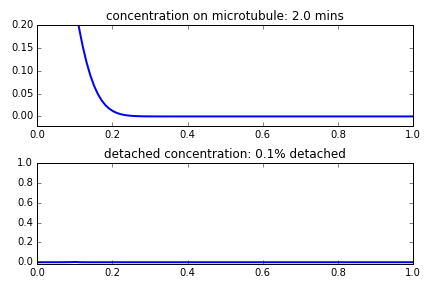
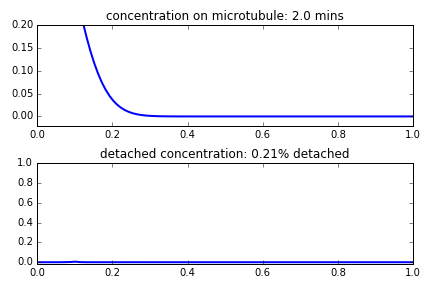
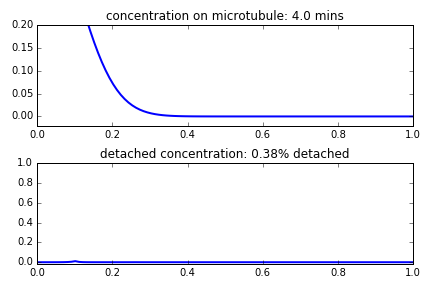
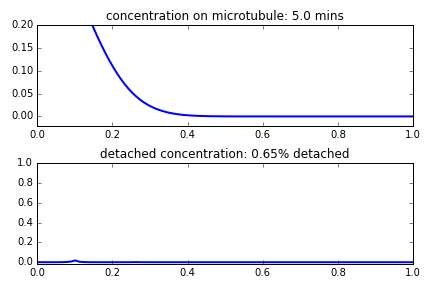
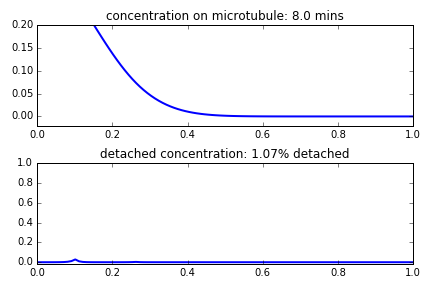
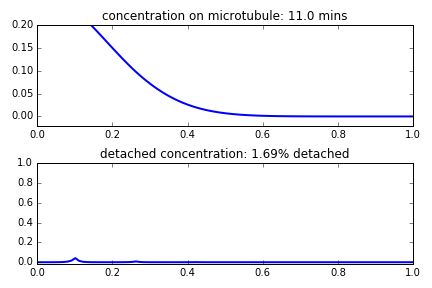
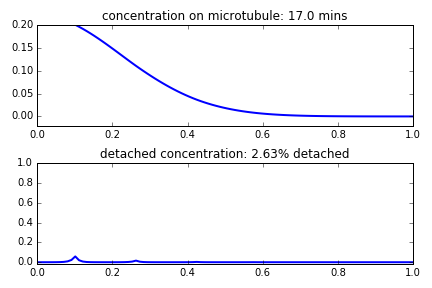
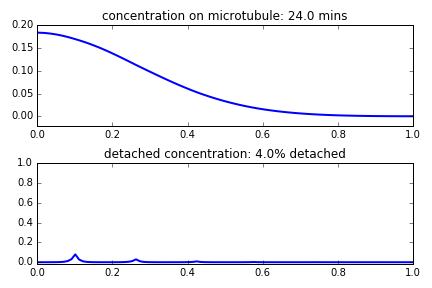
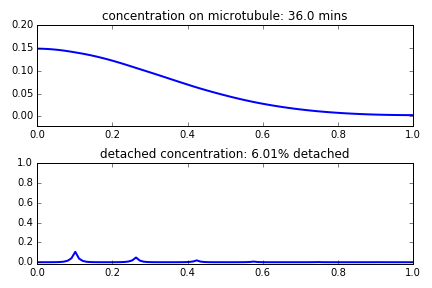
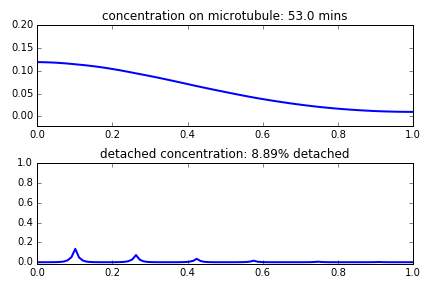
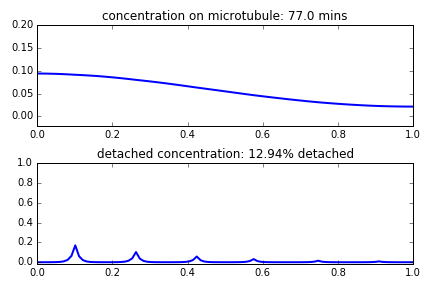
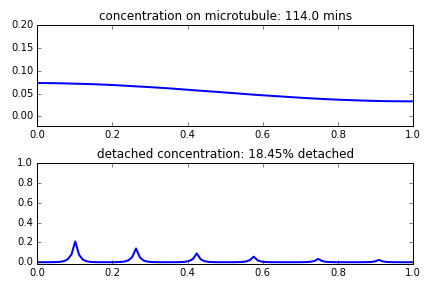
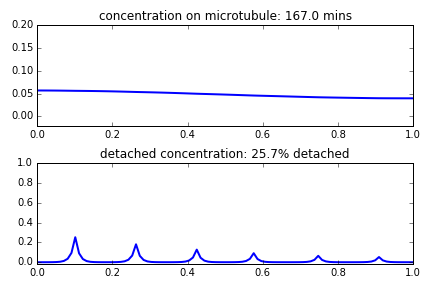
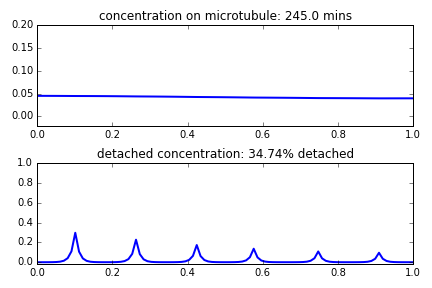
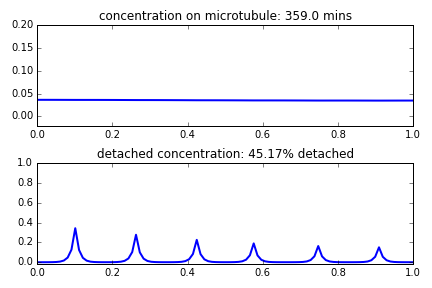
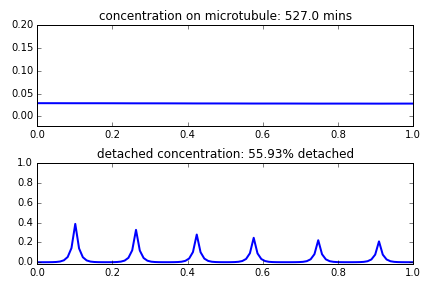
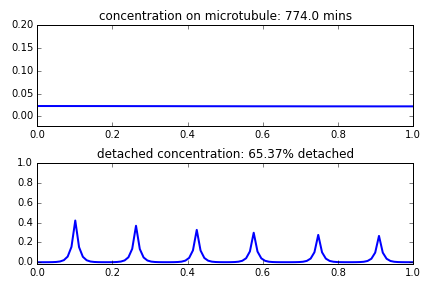
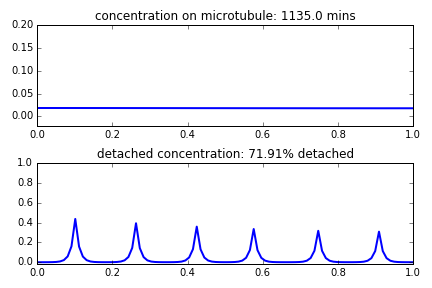
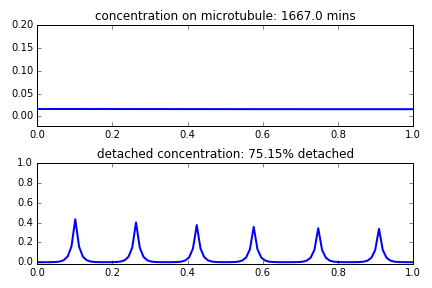
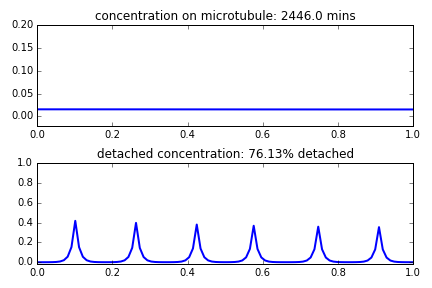
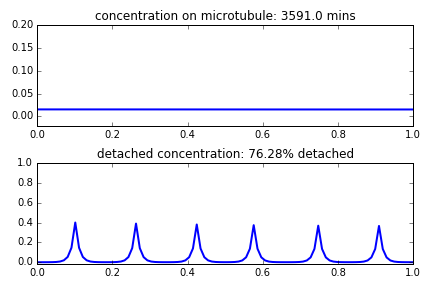
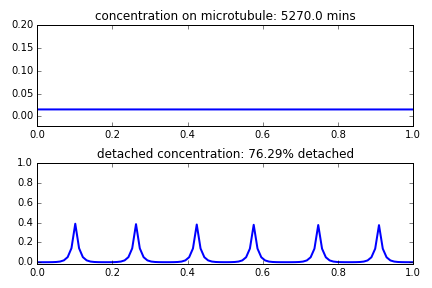
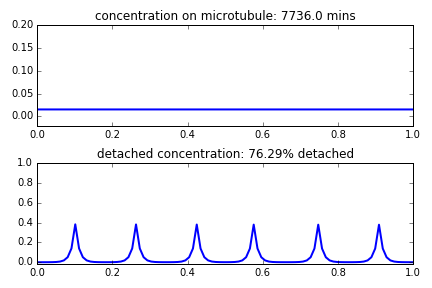
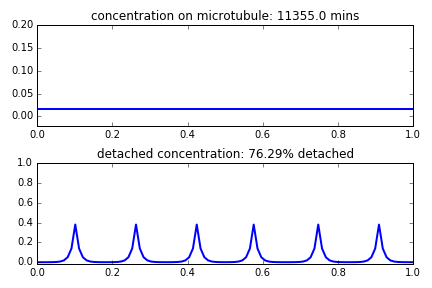
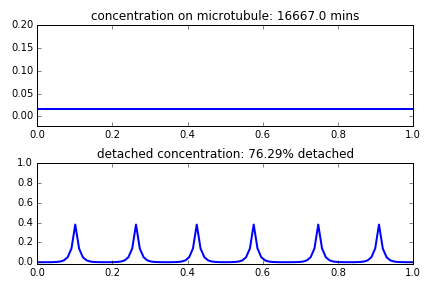
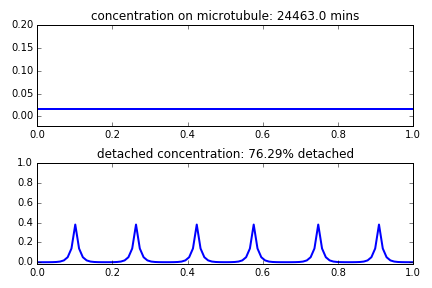
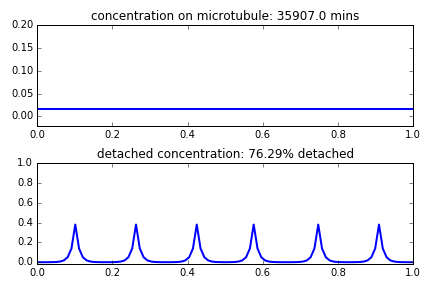
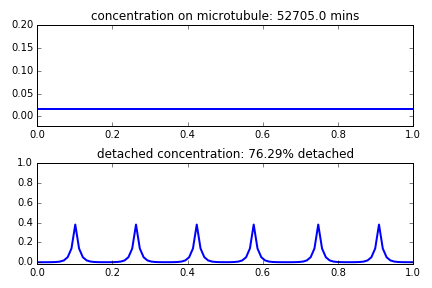

In [5]:
fig,animate,init = sim(5e-4,1e-5,np.logspace(0,6.5,nt),filename='03')
ani3 = animation.FuncAnimation(fig, animate, init_func=init, frames=nt, interval=100)
ani3.save('03.mp4');ani3

### Tradeoff curves

* **Note:** these results depend on $N$, the number of compartments (i.e. number of diffusion traps or delivery sites). The code assumes $N=100$, which some may consider a large underestimate if you consider each synapse as a separate delivery site. Increasing $N$ will make these tradeoff curves more severe because there are more local traps.
* The parameters are otherwise the same as the tradeoff curve in figure 6. Briefly, we have a 800 micron cable, with 100 compartments, the trafficking rates are constrained so that $a_i+b_i=0.5$, which sets the diffusion coefficient so that the mean square displacement increases at a rate of 4 $\mu m^2$ per second, see code/notebook for figure 1 and 6).

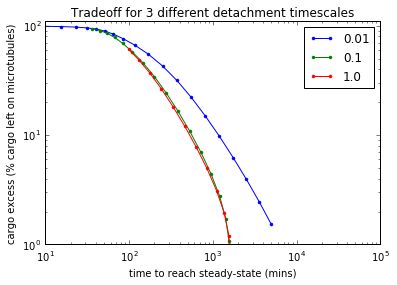

In [6]:
#y = np.ones(N)*6/N
y = get_target_profile(6)
plt.figure()
detach_timescales = [1e-2,1e-1,1e0]
for cs in detach_timescales:
    tau,excess = calc_tradeoff_curve(y,cs)
    plt.plot(tau/60,excess*100,'.-')
plt.ylim([1.0,110.0])
plt.xlim([1e1,1e5])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('time to reach steady-state (mins)')
plt.ylabel('cargo excess (% cargo left on microtubules)')
plt.title('Tradeoff for 3 different detachment timescales')
plt.legend(detach_timescales)
plt.savefig('reattach_tradeoff_100.svg')
plt.show()

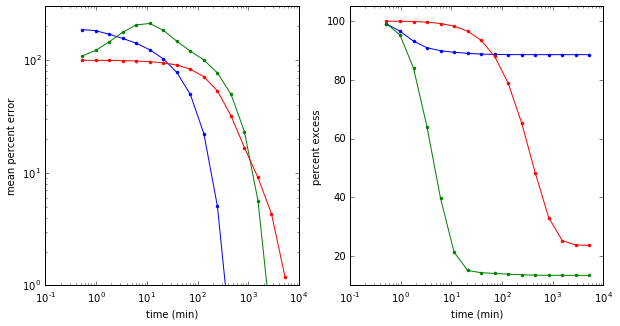

In [7]:
plt.figure(figsize=(10,5))

# for cs in [1e-3,1e-2,1e-1]:
#     for ds in [1e-3,1e-2,1e-1]:

for cs,ds in [(2e-1,1e-1), (1e-1,1e-3), (5e-4,1e-5)]:
    t,err,excess = err_vs_time(cs,ds)
    plt.subplot(1,2,1)
    l = plt.plot(t/60,err,'.-')
    plt.subplot(1,2,2)
    plt.plot(t/60,excess,'.-')

#plt.setp(l, 'color', 'k')

plt.subplot(1,2,1)
#plt.ylim([1e-12,1e-1])
plt.ylim([1,300])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('time (min)')
plt.ylabel('mean percent error')
plt.subplot(1,2,2)
plt.ylim([10,105])
plt.xscale('log')
plt.xlabel('time (min)')
plt.ylabel('percent excess')
plt.savefig('err_v_time.svg')
plt.savefig('err_v_time.eps')
plt.show()